In [1]:
import pandas as PD
import numpy as NP
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, cv, DMatrix

import preprof      #my functions

In [2]:
######## to run with the naive dataset, uncomment the following:

# full=False




######## to fun with the full dataset, uncomment below:

full=True




In [3]:
## initialise dataset

if full:
    csv = '/Users/cdw/Desktop/pkpd_script/RNR_ANALYSIS/ready_processed.csv'
else:
    csv = '/Users/cdw/Desktop/pkpd_script/RNR_ANALYSIS/all.csv'

In [4]:
## convert to relevant or not relevant

preprof.tidy_categories(csv)
preprof.binary_categories(csv)
    
papers=PD.read_csv(csv)

In [5]:
## convert into bow/tfidf

rd_seed = 61097
x = [a.split('!$!') for a in papers.loc[:,'words']]
y = papers.loc[:,'category']

def fake_tokeniser(text):
    return text

bag_of_words = CountVectorizer(analyzer='word',tokenizer=fake_tokeniser,preprocessor=fake_tokeniser,lowercase=False,token_pattern=None)
tf_idf = TfidfVectorizer(analyzer='word',tokenizer=fake_tokeniser,preprocessor=fake_tokeniser,lowercase=False,token_pattern=None)

def wm2df(wm, feat_names):  
    doc_names = [f'Doc{idx}' for idx, _ in enumerate(wm)]
    df = PD.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

bow = bag_of_words.fit_transform(x)
bow_names = bag_of_words.get_feature_names()
bow_matrix = wm2df(bow,bow_names)

tfidf = tf_idf.fit_transform(x)
tfidf_names = tf_idf.get_feature_names()
tfidf_matrix = wm2df(tfidf,tfidf_names)

In [6]:
##split train/test

x_train_b,x_test_b,y_train_b,y_test_b=train_test_split(bow,y,test_size=0.15,random_state=rd_seed,stratify=y)
x_train_t,x_test_t,y_train_t,y_test_t=train_test_split(tfidf,y,test_size=0.15,random_state=rd_seed,stratify=y)

In [7]:
## save tfidf dataframe WITHOUT feature names because it trains the xgboost model faster
pickle.dump(bow,open('bow_nofeats','wb'))
pickle.dump(tfidf,open('tfidf_nofeats','wb'))

In [8]:
## print proportions of relevant/notrelevant papers in train/test set data.

preprof.print_proportions(y_train_b,y_test_b)

TRAINING
 Not relevant    63.789869
Relevant        36.210131
Name: category, dtype: float64

TESTING
 Not relevant    63.60424
Relevant        36.39576
Name: category, dtype: float64


In [9]:
preprof.print_proportions(y_train_t,y_test_t)

TRAINING
 Not relevant    63.789869
Relevant        36.210131
Name: category, dtype: float64

TESTING
 Not relevant    63.60424
Relevant        36.39576
Name: category, dtype: float64


# evaluation of classifiers

In [10]:
acc_scores={}
f1_scores={}

In [11]:
## appends accuracy&f1 of a classifier to the acc_scores and f1_scores dicts

def assess_classifier(cls,name,**args):
    global x_train_b,x_test_b,y_train_b,y_test_b,x_train_t,x_test_t,y_train_t,y_test_t
    global acc_scores,f1_scores
    
    for k,v in args.items():
    
        if v=='bow':
            cls.fit(x_train_b,y_train_b)
            y_pred=cls.predict(x_test_b)
            acc=accuracy_score(y_test_b,y_pred)
            acc_scores[name+'_b']=acc
            f1=f1_score(y_test_b,y_pred,pos_label='Relevant')
            f1_scores[name+'_b']=f1

        if v=='tfidf':
            cls.fit(x_train_t,y_train_t)
            y_pred=cls.predict(x_test_t)
            acc=accuracy_score(y_test_t,y_pred)
            acc_scores[name+'_t']=acc
            f1=f1_score(y_test_t,y_pred,pos_label='Relevant')
            f1_scores[name+'_t']=f1

In [12]:
## create classifier objects

mnb=MultinomialNB()
svc=LinearSVC(max_iter=10000)
lr=LogisticRegression(solver='liblinear')
dtc=DecisionTreeClassifier()
gbc=GradientBoostingClassifier()
xgb=XGBClassifier()

In [13]:
## evaluate each classifier using bow and tfidf

classifiers = {mnb:'mnb',svc:'svc',lr:'lr',dtc:'dtc',gbc:'gbc',xgb:'xgb'}

counter=0
for cls,name in classifiers.items():
    counter+=1
    assess_classifier(cls,name,type='tfidf')
    print('{}_t'.format(counter),end='  ')
    assess_classifier(cls,name,type='bow')
    print('{}_b'.format(counter),end='\n')

1_t  1_b
2_t  2_b
3_t  3_b
4_t  4_b
5_t  5_b
6_t  6_b


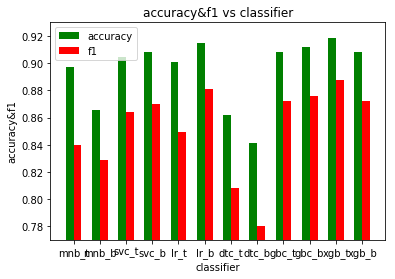

In [14]:
## plot accuracy & f1 of the evaluated classifiers

x=NP.array([x for x in range(len(acc_scores))])
ax = plt.subplot(111)
ax.bar(x-0.15,acc_scores.values(),width=0.3,color='g',align='center',label='accuracy')
ax.bar(x+0.15, f1_scores.values(),width=0.3,color='r',align='center',label='f1')
plt.xticks(x,acc_scores.keys())
plt.ylim((0.77,0.93))
plt.legend()
plt.title('accuracy&f1 vs classifier')
plt.ylabel('accuracy&f1')
plt.xlabel('classifier')
plt.savefig('cls_rnr.png')
plt.show()

therefore the best classifiers (with no hyperparameter tuning) are<br>
1)  LOGISTIC REGRESSION BoW<br>
2)  XGBOOST TFIDF